In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
from pytz import timezone
import MySQLdb
import time
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import Queue
est = timezone('US/Eastern')

Using TensorFlow backend.


In [2]:
btc = pd.read_csv('binance-data.csv')
twitter_sent = pd.read_csv('live_tweet.csv')
reddit_sent = pd.read_csv('live_reddit.csv')

btc.columns = ["Price","Volume", "Number_Trades", "Market_Cap","Supply", "Stamp"]
twitter_sent.columns = ["Sentiment", "Stamp"]
reddit_sent.columns = ["Sentiment", "Stamp"]

merged = pd.merge(twitter_sent, btc,  on='Stamp', how='inner').merge(reddit_sent, on='Stamp', how='inner')
data = merged[["Sentiment_x", "Sentiment_y","Volume", "Market_Cap", "Supply", "Number_Trades", "Price"]].groupby(merged['Stamp']).mean()
datag = data[["Volume", "Market_Cap", "Supply", "Number_Trades", "Price"]]
tw_sentiment = data["Sentiment_x"]
rdt_sentiment = data["Sentiment_y"]

print "Dataset size: " + str(len(datag))
print "Timespan: " + str(len(datag)/60) + " hours"

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
values = datag.values.reshape(-1, datag.shape[1])
tw_sentiment = tw_sentiment.values.reshape(-1, 1)
rdt_sentiment = rdt_sentiment.values.reshape(-1, 1)
tw_sentiment = tw_sentiment.astype('float32')
rdt_sentiment = rdt_sentiment.astype('float32')
values = values.astype('float32')
scaled = scaler.fit_transform(values)

Dataset size: 1313
Timespan: 21 hours


915
390
Done


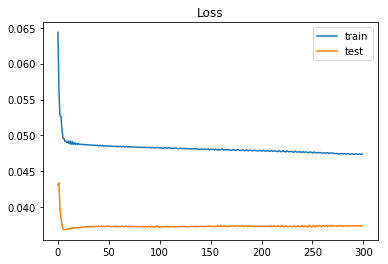

In [3]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
split = train_size

def create_dataset(dataset, look_back, tw_sentiment, rdt_sentiment, sent=False):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        if i >= look_back:
            a = dataset[i-look_back:i+1, 0]
            a = a.tolist()
            if(sent==True):                
                current_tw_sentiment = tw_sentiment[i].tolist()[0]
                current_rdt_sentiment = rdt_sentiment[i].tolist()[0]
                a.append(current_tw_sentiment)
                a.append(current_rdt_sentiment)
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

look_back = 2
trainX, trainY = create_dataset(train, look_back, tw_sentiment[0:train_size], rdt_sentiment[0:train_size], sent=True)
testX, testY = create_dataset(test, look_back, tw_sentiment[train_size:len(scaled)], rdt_sentiment[train_size:len(scaled)], sent=True)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Creating new model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.save('models/LSTM_Philip_15-03-2018.h5')

# Loading model
# model = load_model('models/LSTM_12-03-2018_GOOD.h5')

history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)
yhat = model.predict(testX)
# yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
# testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
# rmse_sent = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print "Done"
# print 'Test RMSE: %.3f' % rmse_sent

pyplot.title("Loss")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [5]:
#Enter the values for you database connection
dsn_database = "ai_datasets"         # e.g. "MySQLdbtest"
dsn_hostname = "127.0.0.1"      # e.g.: "mydbinstance.xyz.us-east-1.rds.amazonaws.com"
dsn_port = 3306                  # e.g. 3306 
dsn_uid = "root"             # e.g. "user1"
dsn_pwd = ""              # e.g. "Password123"

conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
cursor=conn.cursor()


In [4]:
true_q = Queue.Queue()
pred_q = Queue.Queue()

threshold = 0.10

def process_data(in_data):
    out_data = []
    for line in in_data:
        out_data.append(float(line.split(',')[0]))
    return np.array(out_data).reshape(-1,1)

In [9]:
trades = []
bought = False
status = 0
to_db = False
prev = 8228

while True:
    
    btc = open('binance-data.csv','r')
    tw_sent = open('live_tweet.csv','r')
    rdt_sent = open('live_reddit.csv','r')
    bit_data = btc.readlines()
    #prev = bit_data[len(bit_data) - 1].split(',')[0]
    tw_sent_data = tw_sent.readlines()
    rdt_sent_data = rdt_sent.readlines()
    
    bit_data = process_data(bit_data[len(bit_data)-5:])
    tw_sent_data = process_data(tw_sent_data[len(tw_sent_data)-5:])
    rdt_sent_data = process_data(rdt_sent_data[len(rdt_sent_data)-5:])
    live = scaler.fit_transform(bit_data)
    testX, testY = create_dataset(live, 2, tw_sent_data, rdt_sent_data, sent=True)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    yhat = model.predict(testX)
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
    true_q.put(bit_data[4])
    pred_q.put(yhat_inverse[0])
    val = 100 * ((yhat_inverse[0][0] - float(prev))/float(prev))
    
    print "Pred: " + str(yhat_inverse[0][0])
    print "Diff: " + str(val)
    
    if val > threshold and not bought:
        decision = 1
        print "Buy at: " + str(prev)
        bought = True
        trades.append(("Buy", str(prev)))
        to_db = True
    elif val <-threshold and bought:
        decision = 2
        print "Sell at: " + str(prev)
        bought = False
        trades.append(("Sold", str(prev)))
        to_db = True
    else:
        to_db = False
    
    if to_db == True:
        input_string = "INSERT INTO live_data (yhat, bit_data, sent_data, reddit_sent, date, decision) values ({},{},{},{},'{}',{});".format(
            yhat_inverse[0][0],
            bit_data[0][0],
            tw_sent_data[4][0],
            rdt_sent_data[4][0],
            datetime.now(tz=est).strftime('%Y-%m-%d %H:%M:%S'),
            decision)
        cursor.execute(input_string)
        conn.commit()
        
    prev = yhat_inverse[0][0]
    
    print trades
    for trade in trades:
        if(trade[0] == "Buy"):
            status = status - float(trade[1])
        if(trade[0] == "Sold"):
            status =  status + float(trade[1])
            
    print "Status:" + str(status)
    status = 0
    time.sleep(60)

1
Pred: 8217.54
Diff: -0.127126409061
[]
Status:0
1
Pred: 8215.36
Diff: -0.0265367013989
[]
Status:0
1
Pred: 8218.32
Diff: 0.0360652588615
[]
Status:0
1
Pred: 8216.21
Diff: -0.0256667350321
[]
Status:0
1
Pred: 8222.31
Diff: 0.0741911535904
[]
Status:0
1
Pred: 8223.11
Diff: 0.00977476007299
[]
Status:0
1
Pred: 8175.01
Diff: -0.584908176708
[]
Status:0
1
Pred: 8175.36
Diff: 0.00421683112905
[]
Status:0
1
Pred: 8174.65
Diff: -0.00870207349448
[]
Status:0
1
Pred: 8175.62
Diff: 0.0118865019452
[]
Status:0
1
Pred: 8164.98
Diff: -0.130090961545
[]
Status:0
1
Pred: 8164.93
Diff: -0.000699681800266
[]
Status:0
1
Pred: 8165.65
Diff: 0.00886867837555
[]
Status:0
1
Pred: 8169.25
Diff: 0.0441182107333
[]
Status:0
1
Pred: 8172.28
Diff: 0.0370816856818
[]
Status:0
1
Pred: 8179.45
Diff: 0.0877525529767
[]
Status:0
1
Pred: 8194.92
Diff: 0.189021630393
Buy at: 8179.45
[('Buy', '8179.45')]
Status:-8179.45


/home/thriven/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:55: Warning:

Data truncated for column 'date' at row 1



1
Pred: 8194.3
Diff: -0.00747176370446
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8194.77
Diff: 0.00570852033008
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8200.9
Diff: 0.0747547055364
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8203.31
Diff: 0.0294722923537
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8206.61
Diff: 0.0401300303457
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8211.29
Diff: 0.0571305222403
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8205.36
Diff: -0.0722375872123
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8206.47
Diff: 0.0134606144919
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8206.07
Diff: -0.00480756529899
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8208.63
Diff: 0.0312268758677
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8216.7
Diff: 0.0983030207568
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8218.73
Diff: 0.0246377870917
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8248.07
Diff: 0.356975743045
[('Buy', '8179.45')]
Status:-8179.45
1
Pred: 8247.71
Diff: -

1
Pred: 8290.22
Diff: -0.0326308649593
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38')]
Status:-8091.33
1
Pred: 8303.93
Diff: 0.165304365352
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38')]
Status:-8091.33
1
Pred: 8302.57
Diff: -0.0163585050467
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38')]
Status:-8091.33
1
Pred: 8297.86
Diff: -0.0567760050747
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38')]
Status:-8091.33
1
Pred: 8290.84
Diff: -0.0845474475474
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38')]
Status:-8091.33
1
Pred: 8270.05
Diff: -0.250700250418
Sell at: 8290.84
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84')]
Status:199.51
1
Pred: 8269.9
Diff

1
Pred: 8240.15
Diff: -0.0121342225127
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3')]
Status:244.63
1
Pred: 8239.52
Diff: -0.00769147081069
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3')]
Status:244.63
1
Pred: 8237.94
Diff: -0.019176821315
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3')]
Status:244.63
1
Pred: 8244.27
Diff: 0.0768879603957
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('S

1
Pred: 8279.85
Diff: -0.187110099001
Sell at: 8295.38
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38')]
Status:290.71
1
Pred: 8273.52
Diff: -0.0765105436412
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38')]
Status:290.71
1
Pred: 8274.12
Diff: 0.00722372526331
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'),

1
Pred: 8294.07
Diff: 0.0142017336242
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68')]
Status:-7969.97
1
Pred: 8293.53
Diff: -0.00646405028442
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68')]
Status:-7969.97
1
Pred: 8291.65
Diff: -0.0227139509346
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '82

1
Pred: 8059.86
Diff: -0.0282473882522
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59')]
Status:-7732.0
1
Pred: 8056.03
Diff: -0.0475082780539
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59')]
Status:-7732.0
1
Pred: 8054.72
Diff: -0.0162678941532
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '829

1
Pred: 8068.28
Diff: -0.00842953369732
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09')]
Status:-7724.69
1
Pred: 8063.96
Diff: -0.0535710859928
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09')]
Status:-7724.69
1
Pred: 8058.33
Diff: -0.0697850988317
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '83

1
Pred: 8012.37
Diff: 0.0292967892767
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29')]
Status:-7667.26
1
Pred: 8014.23
Diff: 0.0231819280417
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29')]
Status:-7667.26
1
Pred: 8018.41
Diff: 0.0521716200

1
Pred: 7949.5
Diff: -0.112032519617
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45')]
Status:348.19
1
Pred: 7940.98
Diff: -0.107256627667
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45')]
Status:348.

1
Pred: 8010.17
Diff: 0.133920140381
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93')]
Status:-7578.74
1
Pred: 8010.59
Diff: 0.00517530255404
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', 

1
Pred: 8050.03
Diff: -0.00353610928628
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21')]
Status:-7565.85
1
Pred: 8055.66
Diff: 0.0698755051417
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold',

1
Pred: 8025.48
Diff: -0.0210892529179
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71')]
Status:491.86
1
Pred: 8040.93
Diff: 0.192465575651
Buy at: 8025.48
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.

1
Pred: 8092.03
Diff: -0.200141975243
Sell at: 8108.26
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26')]
Status:574.64
1
Pred: 8080.77
Diff: -0.139152403108
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290

1
Pred: 8127.16
Diff: 0.236136773242
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91')]
Status:-7523.27
1
Pred: 8130.46
Diff: 0.0406382488111
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '

1
Pred: 8065.72
Diff: -0.132577484282
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46')]
Status:607.19
1
Pred: 8066.32
Diff: 0.00749458776347
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '

1
Pred: 8072.59
Diff: 0.0100296315726
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45')]
Status:616.07
1
Pred: 8072.16
Diff: -0.00534093879792
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', 

1
Pred: 8083.19
Diff: -0.0106304972053
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45')]
Status:616.07
1
Pred: 8063.07
Diff: -0.248919017203
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '

1
Pred: 8039.65
Diff: -0.0152722977825
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45')]
Status:616.07
1
Pred: 8031.98
Diff: -0.0954497391773
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', 

1
Pred: 8055.62
Diff: 0.167245949905
Buy at: 8042.17
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17')]
Status:-7426.1
1
Pred: 8058.55
Diff: 0.0364106946945
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.9

1
Pred: 8075.3
Diff: -0.0469660482794
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17')]
Status:-7426.1
1
Pred: 8084.96
Diff: 0.119535205231
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8

1
Pred: 8109.72
Diff: 0.0900700293574
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14')]
Status:-7410.7
1
Pred: 8111.11
Diff: 0.0171476384577
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', 

1
Pred: 8137.36
Diff: 0.0489158898838
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14')]
Status:-7410.7
1
Pred: 8152.36
Diff: 0.184298979821
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '

1
Pred: 8197.44
Diff: -0.026749466946
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14')]
Status:-7410.7
1
Pred: 8196.01
Diff: -0.0175240401597
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold',

1
Pred: 8181.6
Diff: -0.00995370631446
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14')]
Status:-7410.7
1
Pred: 8181.88
Diff: 0.00341968913772
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold'

1
Pred: 8178.02
Diff: 0.193638286266
Buy at: 8162.22
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22')]
Status:-7398.68
1
Pred: 8181.72
Diff: 0.0452575464869
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266

1
Pred: 8193.76
Diff: 0.0656835149405
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22')]
Status:-7398.68
1
Pred: 8194.53
Diff: 0.00937975393819
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold'

1
Pred: 8230.34
Diff: -0.0314926931614
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22')]
Status:-7398.68
1
Pred: 8230.35
Diff: 9.49231312483e-05
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sol

1
Pred: 8209.12
Diff: -0.173251053828
Sell at: 8223.37
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37')]
Status:824.69
1
Pred: 8208.95
Diff: -0.00202233153651
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8

1
Pred: 8193.33
Diff: -0.0074249808774
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37')]
Status:824.69
1
Pred: 8186.54
Diff: -0.0829323486339
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy',

1
Pred: 8181.25
Diff: -0.0420409180372
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37')]
Status:824.69
1
Pred: 8181.58
Diff: 0.00401666492193
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy',

1
Pred: 8188.33
Diff: -0.0482184849287
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37')]
Status:824.69
1
Pred: 8188.05
Diff: -0.00348843283377
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy'

1
Pred: 8194.74
Diff: -0.036559734902
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97')]
Status:-7364.28
1
Pred: 8194.15
Diff: -0.00723358595669
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold

1
Pred: 8212.36
Diff: -0.0136137763331
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97')]
Status:-7364.28
1
Pred: 8222.3
Diff: 0.121054246929
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', 

1
Pred: 8199.34
Diff: -0.0496530299598
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85')]
Status:851.57
1
Pred: 8192.65
Diff: -0.0815971945143
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy',

1
Pred: 8157.71
Diff: -0.0632926952477
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85')]
Status:851.57
1
Pred: 8165.29
Diff: 0.0928952603545
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', 

1
Pred: 8179.98
Diff: 0.00307424253947
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2')]
Status:-7313.63
1
Pred: 8182.51
Diff: 0.0309265261309
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold',

1
Pred: 8211.32
Diff: 0.0236724231497
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2')]
Status:-7313.63
1
Pred: 8212.67
Diff: 0.0163527027033
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', 

1
Pred: 8205.48
Diff: 0.0140574587019
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06')]
Status:-7291.49
1
Pred: 8213.29
Diff: 0.0951393141139
[('Buy', '8179.45'), ('Sold', '

1
Pred: 8234.75
Diff: 0.0450728355192
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06')]
Status:-7291.49
1
Pred: 8236.55
Diff: 0.021939241583
[('Buy', '8179.45'), ('Sold', '8

1
Pred: 8247.34
Diff: -0.00156297973561
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06')]
Status:-7291.49
1
Pred: 8250.42
Diff: 0.0373818496141
[('Buy', '8179.45'), ('Sold',

1
Pred: 8273.56
Diff: 0.001569879281
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06')]
Status:-7291.49
1
Pred: 8262.14
Diff: -0.138017370383
Sell at: 8273.56
[('Buy', '8179.

1
Pred: 8205.24
Diff: -0.087935666528
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56')]
Status:982.07
1
Pred: 8189.04
Diff: -0.197383720999
[('Buy', '81

1
Pred: 8212.99
Diff: 0.109095012531
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09')]
Status:-7210.02
1
Pred: 8211.03
Diff: -0.0237

1
Pred: 8258.4
Diff: 0.0658499225243
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09')]
Status:-7210.02
1
Pred: 8260.6
Diff: 0.026641

1
Pred: 8201.33
Diff: -0.154615955011
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26')]
Status:1044.24
1
Pred: 

1
Pred: 8209.79
Diff: 0.074280523492
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47')]
Stat

1
Pred: 8205.01
Diff: 0.0400068249738
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47')]
Sta

1
Pred: 8216.64
Diff: 0.0350141055127
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47')]
Sta

1
Pred: 8120.26
Diff: 0.0227708586418
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47'), ('S

1
Pred: 8079.14
Diff: -0.036599492682
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47'), ('S

1
Pred: 8093.44
Diff: 0.0167143407535
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47'), ('S

1
Pred: 8155.51
Diff: 0.0133830355922
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47'), ('S

1
Pred: 8147.76
Diff: -0.0166333310984
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47'), ('

1
Pred: 8162.6
Diff: 0.0325403240018
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47'), ('So

1
Pred: 8124.14
Diff: -0.0870787316398
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47'), ('

1
Pred: 8157.87
Diff: 0.167920645624
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47'), ('So

1
Pred: 8141.41
Diff: 0.00379056549839
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47'), ('

1
Pred: 8122.81
Diff: -0.0920673498188
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47'), ('

1
Pred: 8133.05
Diff: -0.0314913296213
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47'), ('

1
Pred: 8110.44
Diff: -0.262143635642
[('Buy', '8179.45'), ('Sold', '8320.66'), ('Buy', '8277.97'), ('Sold', '8312.81'), ('Buy', '8267.38'), ('Sold', '8290.84'), ('Buy', '8266.67'), ('Sold', '8290.72'), ('Buy', '8235.23'), ('Sold', '8256.3'), ('Buy', '8254.93'), ('Sold', '8260.84'), ('Buy', '8255.21'), ('Sold', '8295.38'), ('Buy', '8260.68'), ('Sold', '8290.56'), ('Buy', '8052.59'), ('Sold', '8041.4'), ('Buy', '8034.09'), ('Sold', '8050.72'), ('Buy', '7993.29'), ('Sold', '8015.45'), ('Buy', '7926.93'), ('Sold', '8023.1'), ('Buy', '8010.21'), ('Sold', '8057.71'), ('Buy', '8025.48'), ('Sold', '8108.26'), ('Buy', '8097.91'), ('Sold', '8130.46'), ('Buy', '8075.57'), ('Sold', '8084.45'), ('Buy', '8042.17'), ('Sold', '8107.54'), ('Buy', '8092.14'), ('Sold', '8174.24'), ('Buy', '8162.22'), ('Sold', '8223.37'), ('Buy', '8188.97'), ('Sold', '8215.85'), ('Buy', '8165.2'), ('Sold', '8217.2'), ('Buy', '8195.06'), ('Sold', '8273.56'), ('Buy', '8192.09'), ('Sold', '8254.26'), ('Buy', '8192.47'), ('S

KeyboardInterrupt: 